In [1]:
import pailab.tools.functional_clustering as funcional_clustering

import numpy as np
import datetime as dt
import logging
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest


%matplotlib inline
logging.basicConfig(level=logging.ERROR)

In [2]:
x_coords = np.arange(0.0,1.0,0.01)

In [3]:
depp = np.array( [3.0, 2.0, 2.0])
#depp2=depp[1,:]

# Create test data

In [4]:
n_samples = 50
n_degree = 5


class CallPayoff:
    def __init__(self, random_state = 42, min_strike = 0, max_strike = 1):
        self._random_state = random_state
        self._min_strike = min_strike
        self._max_strike = max_strike
        
    def create(self, x_coords, n_samples):
        result = np.empty((n_samples,x_coords.shape[0], ))
        strikes = np.random.uniform(self._min_strike,self._max_strike,(n_samples,))
        zero = np.zeros_like(x_coords)
        for i in range(n_samples):
            result[i,:]= np.maximum(x_coords- strikes[i],zero)
        return result
    

class PutPayoff:
    def __init__(self, random_state = 42, min_strike = 0, max_strike = 1):
        self._random_state = random_state
        self._min_strike = min_strike
        self._max_strike = max_strike
        
    def create(self, x_coords, n_samples):
        result = np.empty((n_samples,x_coords.shape[0], ))
        strikes = np.random.uniform(self._min_strike,self._max_strike,(n_samples,))
        zero = np.zeros_like(x_coords)
        for i in range(n_samples):
            result[i,:]= np.maximum(strikes[i]- x_coords,zero)
        return result
    
class Constant:
    def __init__(self, random_state = 42, min_value = -1, max_value = 1):
        self._random_state = random_state
        self._min_value = min_value
        self._max_value = max_value
        
    def create(self, x_coords, n_samples):
        result = np.empty((n_samples,x_coords.shape[0], ))
        values = np.random.uniform(self._min_value,self._max_value,(n_samples,))
        for i in range(n_samples):
            result[i,:]= values[i]
        return result
        
class Polynomial: 
    def __init__(self, random_state = 42,):
        self._random_state = random_state
      
    def create(self, x_coords, n_samples):
        result = np.ones((n_samples,x_coords.shape[0], ))
        for i in range(n_samples):
            
            for j in range(7):
                if np.random.choice([True, True, False]):
                    tmp = np.random.uniform(0.1,0.9)
                    result[i,:] *= (tmp- x_coords)
            result[i,:] = result[i,:]/(np.max(result[i,:])- np.min(result[i,:]))
            #result[i,:] += np.random.uniform(-1.0,1.0)
            
        return result


def eval_call(y, x, strike = 0.0):
    y = np.maximum(x-strike,zero)

def eval_put(y, x, strike = 0.0):
    y = np.maximum(strike-x,zero)
            
def eval_polynomial(y, x, coeff=[]):
    y = np.polyval(x, coeff)


    
def create_sample(base_f, anomaly_f, n_anomaly_f=1):
    if isinstance(base_f, tuple):
        base_f = [base_f]
    if not isinstance(base_f, list):
        base_f = [(base_f, 99,)]
    result = []
    for b in base_f:
        result.append(b[0].create(x_coords, b[1]))
    result.append(anomaly_f.create(x_coords, n_anomaly_f))
    return np.concatenate(result)
        
        
def create_sample_1():
    return create_sample([(CallPayoff(), 50), (PutPayoff(),50)], Constant())
def create_sample_2():
    return create_sample(CallPayoff(), Constant())
def create_sample_3():
    return create_sample(Constant(min_value=-1, max_value=0), Constant(min_value=0.5, max_value=0.6))

def call_payoff(x, strike):
    zero = np.zeros_like(x)
    return np.maximum(x-strike, zero)
def put_payoff(x, strike):
    zero = np.zeros_like(x)
    return np.maximum(strike-x, zero)

In [24]:
sample_1 = create_sample([(Polynomial(),60)], Constant())
d = funcional_clustering.functional_clustering(x_coords, sample_1, rel_tol=0)

C:\Users\Anwender\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


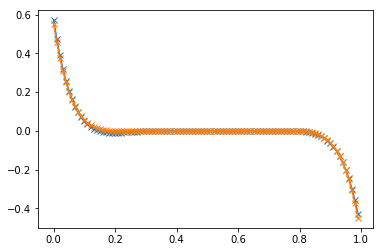

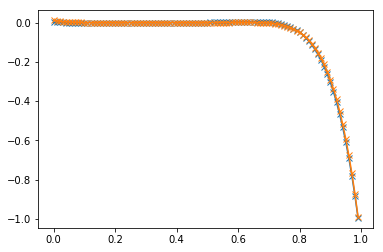

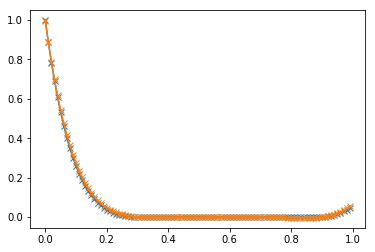

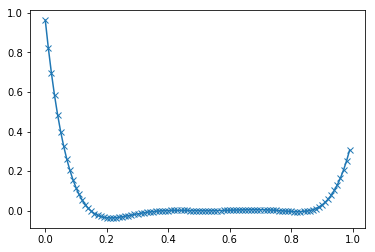

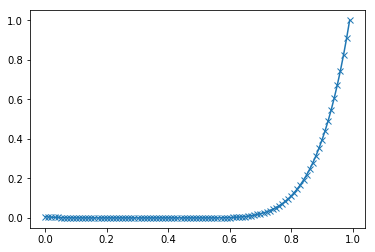

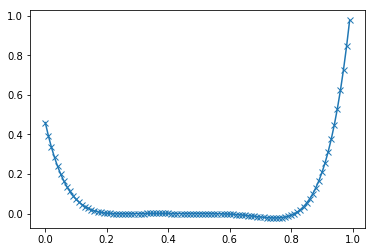

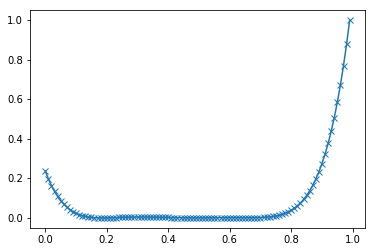

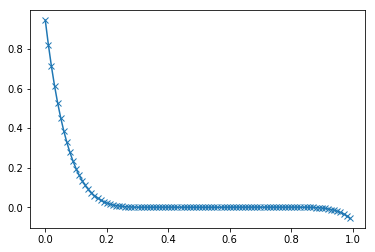

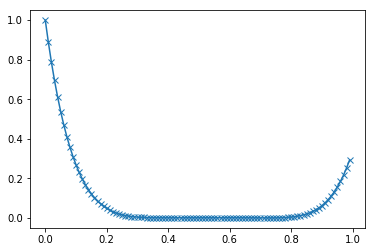

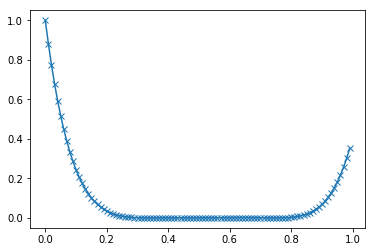

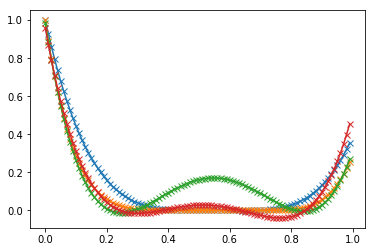

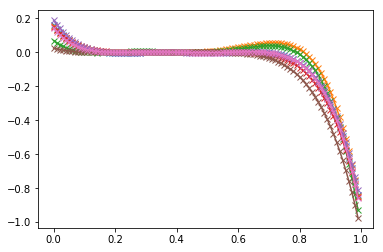

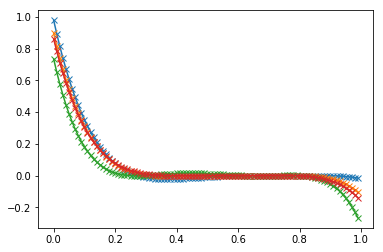

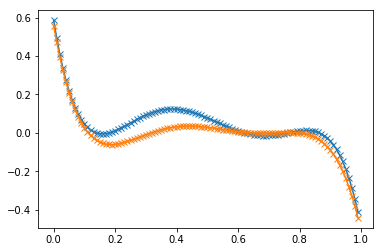

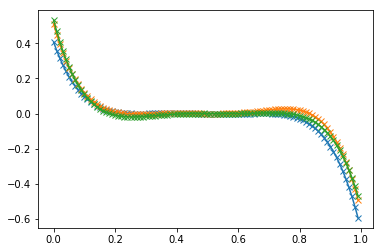

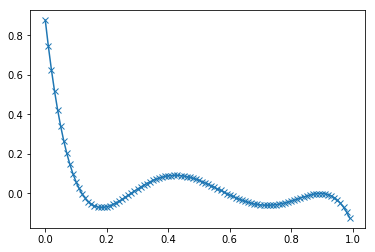

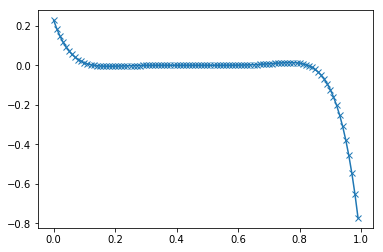

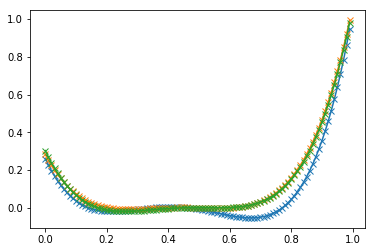

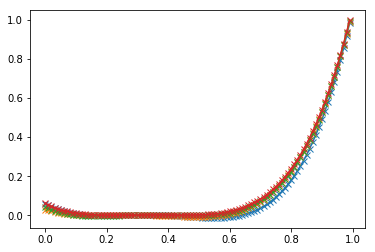

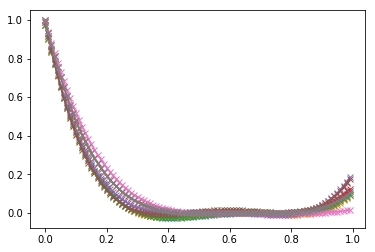

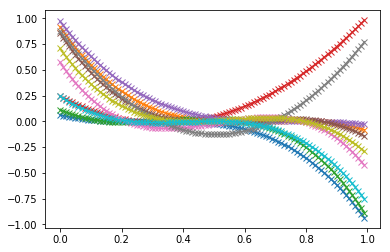

In [33]:
clusters = d.astype(int)
for i in range(np.max(clusters)):
    plt.figure()
    for j in np.nonzero(clusters==i)[0]:
        plt.plot(x_coords, sample_1[j,:],'-x')

In [ ]:
df_f = sample_1[:,1:]-sample_1[:,:-1]
a=np.array([[1.0,2.0,3.0], [0.0,0.0,1.0]])
b = np.array([0.5,0.1])
a[[1,0], :]

In [ ]:
for i in range(sample_1.shape[0]):
    plt.plot(x_coords,sample_1[i,:], '-')

In [ ]:
test_set_1 = {
    'CALL_1':call_payoff(x_coords,0.1),
    'CALL_2':call_payoff(x_coords,0.11),
    'CALL_3':call_payoff(x_coords,0.2),
    #'CALL_4':call_payoff(x_coords,0.1)/0.9,
}

# Statistiken über Funktionen

## Landmarks

A landmark of a curve is a feature with a location that is easily identified at the level of some
derivative or the curve itself. These are typically maximums, minimums or zero crossings. When
all the landmarks are identied we try to align the curves with same landmarks by transforming the time so that all the
landmark locations for all curves coincide.

In [ ]:
def get_local_minimum(f, tol):
    result = []
    for i in range(2,f.shape[0]-2):
        if f[i] < min(f[i-2]+tol, f[i-1], f[i+1], f[i+2]+tol):
            result.append(i)
    return result

def get_local_maxima(f, tol):
    result = []
    for i in range(2,f.shape[0]-2):
        if f[i] > min(f[i-2]+tol, f[i-1], f[i+1], f[i+2]+tol):
            result.append(i)
    return result


## Square-Root Slope Function (SRSF)

$$q(t)=sign(\partial_x f)\sqrt{|\partial_x f|}$$

In [ ]:
def compute_srsf(f):
    dx_f = f[:-1] -f[1,:]
    return np.sign(dx_f)*np.sqrt(np.abs(dx_f))

## Similarity Measure

$$d(f_1,f_2)=\frac{\int_0^1 \partial_x f_1\cdot \partial_x f_2ds}{\sqrt{\int_0^1 (\partial_x f_1)^2ds}\sqrt{\int_0^1 (\partial_x f_2)^2ds}}$$

In [ ]:
def compute_similarity(f1, f2):
    dx_f1 = f1[1:] -f1[:-1]
    dx_f2 = f2[1:] -f2[:-1]
    d1 = np.sqrt(np.dot(dx_f1,dx_f1))
    d2 = np.sqrt(np.dot(dx_f2,dx_f2))
    if d1 < 0.00001 or d2 < 0.00001:
        return 0.0
    return np.dot(dx_f1,dx_f2)/(d1*d2)

In [ ]:
for k,v in test_set_1.items():
    for k2,v2 in test_set_1.items():
        print(k + ', ' + k2 + ': '+ str(compute_similarity(v,v2)))
for k,v in test_set_1.items():
    plt.plot(x_coords, v, label=k)
plt.legend()

In [ ]:
def count_local_min_first_deriv(f):
    pass

class FunctionStat:
        
    @staticmethod
    def normalize_function(f):
        minimum = np.min(f)
        maximum = np.max(f)
        return (f-np.min(f))/(np.max(f)-np.min(f))
    
    @staticmethod
    def count_local_minimum(f, tol):
        result = 0
        for i in range(2,f.shape[0]-2):
            if f[i] < min(f[i-2]-tol, f[i-1], f[i+1], f[i+2]-tol):
                result += 1
        return result
    
    @staticmethod
    def calc_features(functions, tol):
        n_features = 4
        features = np.zeros((functions.shape[0], n_features,))
        
        columns = ['MIN', 'SCALE', 'CURVE_LENGTH', 'NUM_LOCAL_MINIMUMS']
        
        for i in range(functions.shape[0]):
            f = functions[i,:]
            features[i, 0] = np.min(f) # minimum
            
            scale = np.max(f) - features[i,0]
            features[i,1] = scale
            
            if scale < 1e-10:
                f_normalized = f
            else:
                f_normalized = (f-features[i, 0])/(scale)
            
            # compute normalized curve length
            curve_length = 0
            for j in range(1,f.shape[0]):
                curve_length += (f_normalized[j]-f_normalized[j-1])**2
            features[i,2] = curve_length
            
            # compute number of local minimas
            features[i,3] = FunctionStat.count_local_minimum(f_normalized, tol)
        return pd.DataFrame(data=features, columns=columns)
 

In [ ]:


y = np.zeros(shape=(500, x_coords.shape[0]))
tmp = (x_coords-1.0)*x_coords 
for i in range(y.shape[0]):
    p = np.random.uniform(-10,10,size=[8,])
    centers = np.random.uniform(0,1,size=[8,])
    if np.random.choice([True, False]):
        y[i,:] += p[0]*(x_coords-centers[0])*(x_coords-centers[0])*tmp
    if np.random.choice([True, False]):
        y[i,:]+=p[1]*(x_coords-centers[1])*(x_coords-centers[1])*tmp
    if np.random.choice([True, False]):
        y[i,:]+=p[2]*(x_coords-centers[2])*(x_coords-centers[2])*tmp
    if np.random.choice([True, False]):
        y[i,:]+=p[3]*(x_coords-centers[3])*(x_coords-centers[3])*tmp
    
#plt.figure(figsize=(20,10))
#plt.plot(x_coords,y[i,:],'-x', label=str(i));
#plt.legend()
f_features = FunctionStat.calc_features(y, 0.001)

In [ ]:
from sklearn.ensemble import IsolationForest

def get_tree_structure(tree):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    if False:
        print("The binary tree structure has %s nodes and has "
              "the following tree structure:"
              % n_nodes)
        for i in range(n_nodes):
            if is_leaves[i]:
                print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
            else:
                print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                      "node %s."
                      % (node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature[i],
                         threshold[i],
                         children_right[i],
                         ))
    return node_depth, is_leaves

In [ ]:
forest = IsolationForest()
forest.fit(f_features)

In [ ]:
tree = forest.estimators_[0]

def get_distance_matrix(forest):        
    distance_matrix = np.zeros((f_features.shape[0], f_features.shape[0]))
    for tree in forest.estimators_:
        node_depth, is_leaves = get_tree_structure(tree)
        path = tree.decision_path(f_features)
        max_level = max(node_depth)
    
        node_sets = []
        for i in range(f_features.shape[0]):
            node_sets.append(set(path.indices[path.indptr[i]:path.indptr[i+1]]))
        for i in range(f_features.shape[0]):
            for j in range(i+1, f_features.shape[0]):
                distance_matrix[i,j] += max_level / (max([node_depth[x] for x in node_sets[i] & node_sets[j]])+1.0)
                distance_matrix[j,i]  += distance_matrix[i,j] 
    return distance_matrix

get_distance_matrix(forest)

In [ ]:
node_depth

In [ ]:
def get_tree_structure(tree):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    if False:
        print("The binary tree structure has %s nodes and has "
              "the following tree structure:"
              % n_nodes)
        for i in range(n_nodes):
            if is_leaves[i]:
                print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
            else:
                print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                      "node %s."
                      % (node_depth[i] * "\t",
                         i,
                         children_left[i],
                         feature[i],
                         threshold[i],
                         children_right[i],
                         ))
    return node_depth, is_leaves

In [ ]:
(x_coords-0.5)**2 

# Create test data alt

In [ ]:
f = create_sample_1()

In [ ]:
plt.plot(x_coords, f[0,:]);

In [ ]:
class FunctionSampler:
    
    name_to_function = {
        'CALL':eval_call,
        'PUT': eval_put,
        'POLYNOMIAL': eval_polynomial
    }
    stepsize = 0.01
    x_coords = np.arange(0.0,1.0,0.01) 
    
    #
    #example_1 = 
    #        ('CALL', {strike:(0.0,1.0)}, 100, 0,),
    #        ('PUT', {strike:(0.0,1.0)}, 100, 0),
    #        ('POLYNOMIAL', {[1]}, 1, 1)
    #        ]
            
    def create_f(function_name, f_kwargs_template, num_samples, ordinal_category):
        def _draw_random(v):
            if isinstance(v,tuple):
                return np.uniform(v[0], v[1])
            if isinstance(v, list):
                result = np.empty((len(v), ))
                for i in range(len(v)):
                    result[i] = _draw_random(v[i])
                return result
            return v
        
        result = np.empty((num_samples, FunctionSampler.x_coords))
        
        f = FunctionSampler.name_to_function[function_name]
        for i in range(num_samples):
            f_kwargs = {}
            for k,v in f_kwargs_template.items():
                f_kwargs[k] = FunctionSampler.create_f._draw_random(v)
            f(result[i,:],x_coords )
            
    def create_set(f_description, outlier):
        pass
    

In [ ]:
features = create_features(create_sample_1())

In [ ]:
iso_forest = IsolationForest(bootstrap=False, n_estimators=1000, random_state=42)
iso_forest.fit(features)#, bootstrap=True, n_estimators=500)

In [ ]:
plt.plot(iso_forest.score_samples(features),'x')

In [ ]:
def create_stat(iso_forest):
    x = iso_forest.score_samples(features)
    return 1.0 - (x[-1]-np.min(x))
    

In [ ]:
create_stat(iso_forest)

In [ ]:
scores = iso_forest.score_samples(features)
(scores<scores[-1]).sum()

In [ ]:
plt.plot(X[80,:])
plt.plot(X[99,:])

In [ ]:
#Y=X[:,1:]-X[:,0:-1]
np.diff(X,5).shape
#X[:,1:]-X[:,0:-1]

# Alter Kram

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

class DataSampleFunctions:
    
    def __init__(self, x_coords, functions, labels=None):
        self._x_coords=x_coords
        self._functions = functions
        self._labels = labels
        self._X = None
        
    def _create_X(self):
        if self._X is not None:
            return
        
        self._X = np.empty((len(self._functions), self._x_coords.shape[0],))
        for i in range(self._X.shape[0]):
            self._functions[i].evaluate(self._X[i,:], self._x_coords)
            
    def get_X(self):
        self._create_X()
        return self._X
    
    def get_data(self):
        function_params = []*len(self._functions)
        function_type = []*len(self._functions)
        for i in range(self._functions):
            function_type[i] = functions[i].get_type()
            function_params[i] = str(self._functions[i].get_parameter())
        if self._labels is not None:
            return pd.DataFrame({'function_type': function_type, 'function_parameter': function_params})
        else:
            return pd.DataFrame({'function_type': function_type, 'function_parameter': function_params, 'labels': self._labels})
        
    def describe(self):
        print('number of samples: ' + str(len(self._functions)))
        types = defaultdict(int)
        for f in self._functions:
            types[f.get_type()] += 1
        for k,s in types.items():
            print(k + ': ' + str(s))
        if self._labels is not None:
            print('number of outlier: ' + str(self._labels == True))
        pass
    
    def plot(self):
        X = self.get_X()
        if self._labels is None:
            for i in range(X.shape[0]):
                plt.plot(self._x_coords, X[i,:], '-x', 'b')
        else:
            for i in range(X.shape[0]):
                if self._labels[i]:
                    plt.plot(self._x_coords, X[i,:], '-x', 'r')
                else:
                    plt.plot(self._x_coords, X[i,:], '-x', 'b')

In [ ]:

class Polynomial:
    def __init__(self, coeff):
        self._coeff = coeff
      
    def evaluate(self, y, x):
        for j in range(0,len(x)):
            y_=0
            for k in range(len(self._coeff)-1, 0, -1):
                y_ = (y_ + self._coeff[k])*x[j]
                y_ = y[j]
            
            y[j] = y_+ self._coeff[0]
            print(str(y[j]))
            
    def get_type(self):
        return 'Polynomial'

    

In [ ]:
polynoms = [Polynomial([1.0, 0.5]), Polynomial([0.5]), Polynomial([0.8])]# , Polynomial([0.7]), Polynomial([0.7])]

In [ ]:
x_coord = np.arange(0,1.0,0.1)
data = DataSampleFunctions(x_coord, polynoms)

In [ ]:
x_coord

In [ ]:
p = Polynomial([1.0, 0.5])
#y = np.empty(len(x_coord))
y = np.empty((2, x_coord.shape[0],))
#p.evaluate(y[0,:], x_coord)
#p.evaluate(y[1,:], x_coord)

data.get_X()

In [ ]:
class TestData:
    def __init__()

In [ ]:
def create_polynomial_f(data, n_samples, n_degree, x_coords, start_index = 0):
    coeff = 20.0*np.random.rand(n_samples, n_degree) -10.0
    for i in range(n_samples):
        for j in range(len(x_coords)):
            for k in range(1, n_degree):
                data[i+ start_index, j] = (data[i,j] + coeff[i, k])*x_coords[j]
            data[i + start_index,j] += coeff[i,0]
            
def create_heavyside_f(data, n_samples, x_coords, start_index = 0):
    rnd = np.random.rand(n_samples, 3)
    rnd[:,1] = 10.0*rnd[:,1] - 5.0
    rnd[:,2] = 10.0*rnd[:,2] - 5.0
    for i in range(n_samples):
        for j in range(len(x_coords)):
            if x_coords[j] > rnd[i,0]:
                data[i,j] = rnd[i,1]
            else:
                data[i,j] = rnd[i,2]
    

In [ ]:
data = np.zeros([2*n_samples, len(x_coords)])
create_heavyside_f(data, n_samples, x_coords)
create_polynomial_f(data, n_samples, 2, x_coords, n_samples)


In [ ]:
#np.linalg.norm(data, axis=1)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x_coords, data[4,:], 'x')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
new_data = pca.fit_transform(data)



In [ ]:
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
new_data.shape


In [ ]:
coord = [20, 30, 40]
plt.hold
for c in coord:
    new_f = pca.components_[0,:]*new_data[c,0] + pca.components_[1,:]*new_data[c,1] + pca.components_[2,:]*new_data[c,2] + pca.components_[3,:]*new_data[c,3]  + pca.components_[4,:]*new_data[c,4]
    #plt.plot(x_coords, pca.components_[coord,:],'x', x_coords, new_f,'-')
    plt.plot(x_coords, data[c,:],'x', x_coords, new_f,'-')
    
#plt.plot(x_coords, pca.components_[0,:],'x')


In [ ]:
for c in range(pca.components_.shape[0]):
    plt.plot(x_coords, pca.components_[c,:],'-x')

In [ ]:
for c in coord:
    plt.plot(new_data[c],'x')


In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
plt.pcolor(distance_matrix(new_data, new_data))
plt.colorbar()

In [ ]:
import numpy as np
from scipy.stats import lognorm

In [ ]:
def compute_ptf_payoff(weights, payoffs):
    """Return payoff of portfolio at each spot (returns vector)
    weights: vector containing the instrument weights
    payoffs: matrix containing in each row the payoff of respective instrument at each spot
    """
    return weights*payoffs
    
    
def compute_cost(weights, prices):
    return weights*prices

def compute_pnl(weights, prices, payoffs):
    ptf_payoffs = compute_ptf_payoff(weights, prices)
    costs = compute_cost(weights, prices)
    pnl = ptf_payoffs - costs
    
volatility = 0.3
#prob = lognorm.pdf()
pnl = np.zeros(10)


def compute_profit_prob(pnl, prob):
    """Computes probability of positive pnl
    
    pnl: vector containing the pnl for each final spot
    prob: vector containing the probability for each final spot
    """
    return prob[pnl>0].sum()

def compute_optimal_investment(call_strikes, call_prices_bid, call_prices_ask, 
                               put_strikes, put_prices_bid, put_prices_ask, spot_grid, spot_prob):
    pass

In [ ]:
ins = [ {'type': 'C', 'K' : 80} ]
spot_start = 70
spot_end = 130
delta = (spot_end-spot_start)/100.0
spots = [spot_start + i*delta for i in range(100)]


In [ ]:
spots

# Comparison of different norms

In [ ]:
%matplotlib inline

In [ ]:
stepsize = 0.02
x_coords = [i*stepsize for i in range(101)]
import numpy as np

In [ ]:
functions = ['0.5*x', '0.5*x + 3', 'x', '-x','-0.5*x + 0.5', 'x**2', '-x**2', '0.5*x**2', '-0.5*x**2', 'x-0.5']
f_evals = np.empty((len(functions), len(x_coords),))
for i,f in enumerate(functions):
    for j in range(len(x_coords)):
        x=x_coords[j]
        f_evals[i,j] = eval(f)

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(functions)):
    plt.plot(x_coords, f_evals[i,:],  '-x', label = functions[i])
plt.legend()

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
norms = ['euclidean', 'seuclidean', 'cosine', 'hamming', 'canberra']
norm_values = {}
norm_order = {}

In [ ]:
for norm in norms:
    tmp = cdist(f_evals[0:1,:], f_evals,norm)[0]
    tmp2 = [x for x in tmp]
    tmp3 = [x for _,x in sorted(zip(tmp2, functions))]
    norm_order[norm] = tmp3
    result = {}
    for i in range(tmp.shape[0]):
        result[functions[i]] = tmp[i]
    norm_values[norm] = result
    

In [ ]:
import pandas as pd
#pd.DataFrame.from_dict(norm_values)

In [ ]:
pd.DataFrame.from_dict(norm_order)